# Comparing Sentence Encoding Methods to Find Aligned Sentences

This project compares several methods for finding similar sentences, including Jaccard similarity, TF-IDF, GloVe, BERT, and RoBERTa. For this application, we are aligning a user question with the step in a recipe that the question is about. For example, at the end of a lasagna recipe the user might ask "How much ricotta cheese should we use?" That question should be aligned with the step where ricotta cheese is discussed. Here, I analyze which method is best able to align questions with steps using manually tagged data from Instructables.com as the test data. Jaccard similarity is able to achieve the highest precision with a strict threshold that only aligns a small portion of the data, while neural methods offer a good balance of precision and alignment percentage.

In [22]:
import re
import json
import html
import ast
import string
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForNextSentencePrediction, RobertaTokenizer, RobertaModel, GPT2Tokenizer, GPT2Model, GPT2LMHeadModel, GPT2DoubleHeadsModel, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetForSequenceClassification
from sentence_transformers import SentenceTransformer

np.random.seed(1)

## Read in evaluation data

In [2]:
# Instructables (already has clean steps)
data_path = '/alhegel/scrapes/'
instructables_path = 'instructables_clean.jl'
data = []
with open(data_path + instructables_path, 'r') as infile:
    for line in infile:
        line = json.loads(line)
        response_type = line['qapage_schema']['response_type']
        if response_type == 'Question':
            text = line['qapage_schema']['text']
            steps = line['recipe_schema']['recipeInstructions']
            step_ids = list(range(len(steps)))
            url = line['recipe_schema']['url']
            ingredients = line['recipe_schema']['recipeIngredient']
            if not ingredients:
                ingredients = ''
            if isinstance(ingredients, list):
                ingredients = ' '.join(ingredients)

            row = {'question_text': text,
                   'step_ids': step_ids,
                   'steps': steps,
                   'url': url,
                   'ingredients': ingredients}
            data.append(row)

question_sources = ['wikihow_clean.jl', 'food52_clean.jl', 'smittenkitchen_clean.jl']
mixed_sources = ['bbcgoodfood_clean.jl', 'instructables_clean.jl', 'food_clean.jl']
all_sources = question_sources + mixed_sources
for source in all_sources:
    with open(data_path + source, 'r') as infile:
        for line in infile:
            line = json.loads(line)
            if source in mixed_sources:
                if line['qapage_schema']['response_type'].lower() != 'question':
                    continue
            text = line['qapage_schema']['text']
            steps = line['recipe_schema']['recipeInstructions']
            if isinstance(steps, str):
                steps = [x for x in steps.split('\n') if x.strip()]
            step_ids = list(range(len(steps)))
            url = line['recipe_schema']['url']
            if 'recipeIngredient' in line['recipe_schema']:
                ingredients = line['recipe_schema']['recipeIngredient']
                if isinstance(ingredients, list):
                    ingredients = ' '.join(ingredients)  # SHOULD INGREDIENTS BE A LIST?
            else:
                ingredients = ''

            row = {'question_text': text,
                   'step_ids': step_ids,
                   'steps': steps,
                   'url': url,
                   'ingredients': ingredients}
            data.append(row)

raw_df = pd.DataFrame(data)
raw_df

,question_text,step_ids,steps,url,ingredients
0,I feel like there's a lot of content missing f...,"[0, 1, 2, 3, 4, 5]","[Step 2: Scoby. The scoby is the ""mother"" and ...",https://www.instructables.com/id/Kombucha-for-...,"1 gal jar Scoby Filter- can be coffee filter, ..."
1,Is the burning of the bread purely for the col...,"[0, 1, 2]","[Step 2: Burning. burn your bread literaly, I ...",https://www.instructables.com/id/bread-kvass/,I usualy make 25 liters of kvass ( pictures ar...
2,Thanks. Clear insturctable We have a bottle ga...,"[0, 1, 2, 3, 4]","[Step 2: Prepping. Wash the duck legs, dry the...",https://www.instructables.com/id/Duck-Leg-Confit/,8 duck legs (around 250 g each) 1500 g duck fa...
3,I apologize if I missed it - but how many are ...,"[0, 1, 2, 3, 4, 5]",[Step 2: Make the Peanut Butter Mixture. First...,https://www.instructables.com/id/Easy-Homemade...,Ingredients: (Note they don't have to be exact...
4,A relative with a gluten sensitivity told me t...,"[0, 1, 2, 3]","[Step 2: Sugar Stuff. In a saucepan, bring sug...",https://www.instructables.com/id/No-Bake-Cooki...,Ingredients: ¾ cup sugar ½ cup brown sugar ⅓ ...
...,...,...,...,...,...
43633,You say boiled ham but............what exactly...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Melt butter in a large sauté pan and warm the...,https://www.food.com/recipe/brennans-eggs-huss...,2 tablespoons butter 8 slices Canadi...
43634,What is Marmite ?,"[0, 1, 2, 3, 4]",[Bring a small pan of water to the boil. Caref...,https://www.food.com/recipe/british-breakfast-...,"2 medium free-range eggs, at room tempera..."
43635,my dough turned out looking more like frosting...,"[0, 1, 2, 3, 4, 5, 6, 7]","[Preheat oven to 300 degrees F., In a mixing b...",https://www.food.com/recipe/chocolate-shortbre...,"1/4 cup unsalted butter, softened (no sub..."
43636,"If I use chicken thighs, how many per this rec...","[0, 1, 2, 3, 4, 5]",[Place all the ingredients in a saucepan over ...,https://www.food.com/recipe/japanese-mums-chic...,"8 chicken drumsticks, skin on (the skin..."


In [6]:
# Get manually tagged data for evaluation
fname = 'step_alignment_manual_tags.csv'
label_df = pd.read_csv(fname)
label_df

,question_text,step_id,step_text,url,ingredients,aligned
0,Do these cookies freeze well?,0,Preheat oven to 350.,https://www.food.com/recipe/linzer-tarts-191826,1 cup margarine 1/2 cup sugar 1 lar...,0
1,Do these cookies freeze well?,1,Beat margarine at medium speed with an electri...,https://www.food.com/recipe/linzer-tarts-191826,1 cup margarine 1/2 cup sugar 1 lar...,0
2,Do these cookies freeze well?,2,Roll dough into small balls and place on greas...,https://www.food.com/recipe/linzer-tarts-191826,1 cup margarine 1/2 cup sugar 1 lar...,0
3,Do these cookies freeze well?,3,Dip a thimble or small round cutter in flour a...,https://www.food.com/recipe/linzer-tarts-191826,1 cup margarine 1/2 cup sugar 1 lar...,0
4,Do these cookies freeze well?,4,Bake for 8 to 10 minutes or until set. (The c...,https://www.food.com/recipe/linzer-tarts-191826,1 cup margarine 1/2 cup sugar 1 lar...,0
...,...,...,...,...,...,...
1986,Can I make this recipe with rice Thai noodles?,5,Stir the ingredients.,https://www.wikihow.com/Cook-Basic-Japanese-Ramen,300ml of water 2-3 tbsp of soy sauce 2 tsp of ...,0
1987,Can I make this recipe with rice Thai noodles?,6,Wait for about 5 minutes for the flavors to co...,https://www.wikihow.com/Cook-Basic-Japanese-Ramen,300ml of water 2-3 tbsp of soy sauce 2 tsp of ...,0
1988,Can I make this recipe with rice Thai noodles?,7,Strain the soup in a strainer then put it in a...,https://www.wikihow.com/Cook-Basic-Japanese-Ramen,300ml of water 2-3 tbsp of soy sauce 2 tsp of ...,0
1989,Can I make this recipe with rice Thai noodles?,8,Strain the noodles as well and put it in the s...,https://www.wikihow.com/Cook-Basic-Japanese-Ramen,300ml of water 2-3 tbsp of soy sauce 2 tsp of ...,1


In [7]:
label_df['aligned'].value_counts()

0    1739
1     252
Name: aligned, dtype: int64

In [10]:
input_data = label_df[['question_text', 'step_text', 'aligned']]
ing_input_data = label_df[['question_text', 'step_text', 'ingredients', 'aligned']]

In [11]:
def jaccard_similarity(a, b, binary=True):
    if binary:
        similarity = np.double(np.bitwise_and(a, b).sum()) / np.double(np.bitwise_or(a, b).sum())
    else:
        numerator = np.minimum(a, b).sum()
        denominator = np.maximum(a, b).sum()
        similarity = numerator/denominator
    return similarity

In [12]:
# Evaluation methods
def find_threshold_with_best_precision(threshold_df, min_percent_aligned=.01):
    pivot = threshold_df.pivot(index='abs_threshold', columns='measure', values='value').reset_index()
    pivot = pivot.sort_values(by=['Precision', 'Percent Aligned'], ascending=False)
    valid = pivot[pivot['Percent Aligned'] >= min_percent_aligned]
    if len(valid) > 0:
        return valid.iloc[0]['abs_threshold']
    else:
        return pivot.iloc[0]['abs_threshold']

def find_threshold_with_best_balance(threshold_df):
    pass

In [13]:
def show_classification_results(y_true, y_pred, input_idx, input_data):
    # print(classification_report(y_true, y_pred))
#     print('Percent correct:\t\t', accuracy_score(y_true, y_pred))
    print('Precision:\t', precision_score(y_true, y_pred))
    print('Recall:\t\t', recall_score(y_true, y_pred))
    print('F1 score:\t', f1_score(y_true, y_pred))
    print('Percent aligned:', sum(y_pred)/len(input_data))

In [14]:
def show_misclassified_examples(input_data, y_true, y_pred, all_scores, input_idx, exs_to_show=5):
    count_a, count_b, list_a, list_b = 0, 0, [], []
    for i, idx in enumerate(input_idx):
        if count_a < exs_to_show or count_b < exs_to_show:
            if y_true[i] != y_pred[i]:
                output = 'Question: ' + input_data.loc[idx]['question_text'] + \
                         '\n\n' + input_data.loc[idx]['step_text'] + '\n' + str(all_scores[i])
                if y_pred[i] == 1 and count_a < exs_to_show:
                    list_a.append(output)
                    count_a += 1
                elif y_pred[i] == 0 and count_b < exs_to_show:
                    list_b.append(output)
                    count_b += 1
        else:
            break
    print('MISCLASSIFIED AS ALIGNED')
    print('\n\n---\n\n'.join(list_a))
    print('\n\nMISCLASSIFIED AS NOT ALIGNED')
    print('\n\n---\n\n'.join(list_b))

## Count question word appearance in each step (removing stopwords)

In [ ]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc.lower()) if t not in stopwords.words('english')]

all_text = raw_df.apply(
    lambda x: x['question_text'] + ' ' + ' '.join(x['steps']), axis=1).values

vectorizer_stop = CountVectorizer(stop_words='english')
vectorizer_stop.fit(all_text)

vectorizer_lemma = CountVectorizer(tokenizer=LemmaTokenizer())
vectorizer_lemma.fit(all_text)

In [ ]:
def count_question_words(input_data, abs_threshold=0.0, lemmatize=False):
    y_true, y_pred, count_scores, input_idx = [], [], [], []
    for idx, row in input_data.iterrows():
        if lemmatize:
            vectorizer = vectorizer_lemma
        else:
            vectorizer = vectorizer_stop
        question_vector = vectorizer.transform([row['question_text']]).toarray().squeeze()
        step_vector = vectorizer.transform([row['step_text']]).toarray().squeeze()
        # Calculate count score
        score = 0
        for question_word_idx in range(len(question_vector)):
            if question_vector[question_word_idx] > 0:
                score += question_vector[question_word_idx] * step_vector[question_word_idx]
        # Normalize for number of words in step
        score = score / step_vector.sum()

        if score > abs_threshold:
            pred = 1
        else:
            pred = 0
        y_true.append(row['aligned'])
        y_pred.append(pred)
        count_scores.append(score)
        input_idx.append(idx)
    return y_true, y_pred, count_scores, input_idx

def make_precision_plot_count(input_data, abs_threshold_range=(0, .11, .02), lemmatize=False):
    threshold_df = pd.DataFrame(columns=['abs_threshold', 'measure', 'value'])
    for abs_threshold in abs_threshold_range:
        y_true, y_pred, count_scores, input_idx = count_question_words(
            input_data, abs_threshold=abs_threshold, lemmatize=lemmatize)
        precision = precision_score(y_true, y_pred)
        percent_aligned = sum(y_pred)/len(input_data)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Precision', 'value': precision}, ignore_index=True)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Percent Aligned', 'value': percent_aligned}, ignore_index=True)
    return threshold_df

In [ ]:
threshold_df = make_precision_plot_count(input_data, abs_threshold_range=np.arange(0, .61, .01))

In [ ]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [ ]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = count_question_words(input_data, abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

In [ ]:
show_misclassified_examples(input_data, y_true, y_pred, count_scores, input_idx)

In [ ]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = count_question_words(input_data, abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

In [ ]:
show_misclassified_examples(input_data, y_true, y_pred, count_scores, input_idx)

### Lemmatize words

In [ ]:
threshold_df = make_precision_plot_count(input_data, abs_threshold_range=np.arange(0, .61, .05), lemmatize=True)

In [ ]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [ ]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = count_question_words(
    input_data, abs_threshold=best_precision_threshold, lemmatize=True)
show_classification_results(y_true, y_pred, input_idx, input_data)

In [ ]:
show_misclassified_examples(input_data, y_true, y_pred, count_scores, input_idx)

In [ ]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = count_question_words(
    input_data, abs_threshold=percent_aligned_threshold, lemmatize=True)
show_classification_results(y_true, y_pred, input_idx, input_data)

In [ ]:
show_misclassified_examples(input_data, y_true, y_pred, count_scores, input_idx)

## Jaccard Similarity

Intersection over union

In [15]:
a = 'words are fun and cool'
b = 'and I like them cool'
av = [word for word in word_tokenize(a) if word not in stopwords.words('english')]
bv = [word for word in word_tokenize(b) if word not in stopwords.words('english')]

intersection = len(list(set(av).intersection(bv)))
union = (len(av) + len(bv)) - intersection
float(intersection)/union

0.2

In [16]:
def compare_jaccard_similarity(input_data, abs_threshold=0.0):
    y_true, y_pred, count_scores, input_idx = [], [], [], []
    for idx, row in input_data.iterrows():
        question_vector = [word for word in word_tokenize(row['question_text'].lower()) if word not in stopwords.words('english')]
        step_vector = [word for word in word_tokenize(row['step_text'].lower()) if word not in stopwords.words('english')]
        # Calculate jaccard similarity score
        intersection = len(list(set(question_vector).intersection(step_vector)))
        union = (len(question_vector) + len(step_vector)) - intersection
        score = float(intersection)/union

        if score > abs_threshold:
            pred = 1
        else:
            pred = 0
        y_true.append(row['aligned'])
        y_pred.append(pred)
        count_scores.append(score)
        input_idx.append(idx)
    return y_true, y_pred, count_scores, input_idx

def make_precision_plot_jaccard(input_data, abs_threshold_range=(0, .11, .02)):
    threshold_df = pd.DataFrame(columns=['abs_threshold', 'measure', 'value'])
    for abs_threshold in abs_threshold_range:
        y_true, y_pred, count_scores, input_idx = compare_jaccard_similarity(
            input_data, abs_threshold=abs_threshold)
        precision = precision_score(y_true, y_pred)
        percent_aligned = sum(y_pred)/len(input_data)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Precision', 'value': precision}, ignore_index=True)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Percent Aligned', 'value': percent_aligned}, ignore_index=True)
    return threshold_df

In [ ]:
threshold_df = make_precision_plot_jaccard(input_data, abs_threshold_range=np.arange(0, .26, .025))

In [ ]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [ ]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = compare_jaccard_similarity(input_data, abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

In [ ]:
show_misclassified_examples(input_data, y_true, y_pred, count_scores, input_idx)

In [ ]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = compare_jaccard_similarity(input_data, abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

In [ ]:
show_misclassified_examples(input_data, y_true, y_pred, count_scores, input_idx)

### Customized Jaccard Similarity
Control for long instructions by taking the intersection minus stopwords and keywords (ignore union).

In [62]:
def compare_jaccard_similarity_custom(input_data, abs_threshold=0.0, lemmatize=False):
    y_true, y_pred, count_scores, input_idx = [], [], [], []
    for idx, row in input_data.iterrows():
        extra_stopwords = stopwords.words('english')
        extra_stopwords.extend([':', '.', '...', ',', '?', '!', "n't", '``', '’', "'d", "'s", "'m",
                                '(', ')', '<', '>', ';', '{', '}', '-', '–', '”', '“', "''", '/',
                                'hi', 'hello', 'thank', 'thanks',
                               'think', 'like', 'add', 'use', 'make', 'would', 'could', 'put', 'much', 'also',
                       'made', 'should', 'used', 'using', 'adding', 'making', 'step', 'many', 'work',
                       'may', 'without', 'recipe', 'dish', 'gram', 'grams', 'ml', 'cup', 'cups',
                       'ounce', 'ounces', 'try', 'want', 'sure', 'type', 'look', 'another', 'know',
                       'need', 'ever', 'show', 'since', 'see', 'recipes', 'one', 'get', 'got', 'love',
                       'hour', 'hours', 'minute', 'minutes', 'let', 'buy', 'next', 'first', 'great',
                       'right', 'oz', 'good', 'pretty', 'thing', 'go', 'long', 'include', 'includes',
                       'cooking', 'cook', 'qt', 'prepare', 'well', 'slight', 'maybe', 'going', 'sure',
                       'additional', 'might', 'completely'])

        question_vector = [word for word in word_tokenize(row['question_text'].lower()) if word not in extra_stopwords]
        step_vector = [word for word in word_tokenize(row['step_text'].lower()) if word not in extra_stopwords]
        # Calculate customized jaccard similarity score
#         intersection = len(list(set(question_vector).intersection(step_vector)))
#         union = (len(question_vector) + len(step_vector)) - intersection
#         score = float(intersection)/union
        score = len(list(set(question_vector).intersection(step_vector)))

        if score > abs_threshold:
            pred = 1
        else:
            pred = 0
        y_true.append(row['aligned'])
        y_pred.append(pred)
        count_scores.append(score)
        input_idx.append(idx)
    return y_true, y_pred, count_scores, input_idx

def make_precision_plot_jaccard_custom(input_data, abs_threshold_range=(0, .11, .02), lemmatize=False):
    threshold_df = pd.DataFrame(columns=['abs_threshold', 'measure', 'value'])
    for abs_threshold in abs_threshold_range:
        y_true, y_pred, count_scores, input_idx = compare_jaccard_similarity_custom(
            input_data, abs_threshold=abs_threshold, lemmatize=lemmatize)
        precision = precision_score(y_true, y_pred)
        percent_aligned = sum(y_pred)/len(input_data)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Precision', 'value': precision}, ignore_index=True)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Percent Aligned', 'value': percent_aligned}, ignore_index=True)
    return threshold_df

In [63]:
threshold_df = make_precision_plot_jaccard_custom(input_data,
                                                  abs_threshold_range=np.arange(0, 7.51, 1.0),
                                                  lemmatize=False)

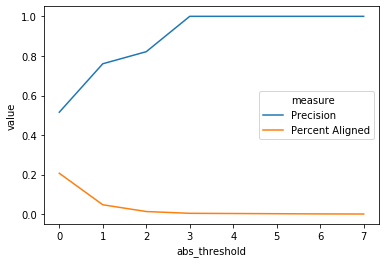

In [64]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [65]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = compare_jaccard_similarity_custom(
    input_data, abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 2.0
Precision:	 0.8214285714285714
Recall:		 0.09126984126984126
F1 score:	 0.16428571428571428
Percent aligned: 0.014063284781516826


In [66]:
show_misclassified_examples(input_data, y_true, y_pred, count_scores, input_idx)

MISCLASSIFIED AS ALIGNED
Question: I’m allergic to dairy – do you think I could substitute coconut milk and cream? I’ve seen coconut condensed milk around that I know I can get. I’d love to try the almond milk version but its not coming to australia…

In the bottom of a pitcher, whisk cocoa powder and a spoonful of cream into a paste. Slowly, whisking the whole time, add more cream a spoonful at a time until the paste is smooth and loose enough that you can whisk the rest of the cream in larger splashes. Once all of the cream is in, whisk in condensed milk, whiskey and vanilla. Cover with lid or plastic wrap and keep in fridge for up to two weeks, possibly longer.   Serve in a tiny tumbler filled with ice, or splashed into coffee.
3

---

Question: How much cream of tartar do I add to baking soda to equal 1 tablespoon of baking powder?

Store the mix in an airtight container if you’re not using it right away. Use a resealable plastic container and store it in your pantry. Make sure no 

In [67]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = compare_jaccard_similarity_custom(
    input_data, abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 10.0 % aligned: 0.0
Precision:	 0.5157384987893463
Recall:		 0.8452380952380952
F1 score:	 0.6406015037593986
Percent aligned: 0.2074334505273732


In [68]:
show_misclassified_examples(input_data, y_true, y_pred, count_scores, input_idx)

MISCLASSIFIED AS ALIGNED
Question: Do these cookies freeze well?

Dip a thimble or small round cutter in flour and cut out a small circle in the center of exactly half of the cookies.
1

---

Question: Do these cookies freeze well?

Bake for 8 to 10 minutes or until set.  (The cookies will be pale.  The cut out halves will bake faster so watch closely.)  Transfer carefully to wire racks to cool.
1

---

Question: Do these cookies freeze well?

Spread raspberry preserves on top of solid cookies.  Top with remaining cookies, bottom sides down, to make sandwiches.  Sift powdered sugar over tops of cookies.
1

---

Question: I am planning to try this today. Just have one question. Do I need to whip the whipping cream separately before adding it in the cheese mixture? Appreciate everyone’s feedback. Thanks.

Mix cream cheese, sugar, flour, and vanilla.
2

---

Question: I'm curious what the foil between the pan and the lid is for. The new Staub dutch ovens have the dimples on the lid to aut

## BLEU Score

In [35]:
chencherry = SmoothingFunction()

def compare_bleu_score(input_data, abs_threshold=0.0):
    y_true, y_pred, all_bleu_scores, input_idx = [], [], [], []
    for idx, row in input_data.iterrows():
        question = [word_tokenize(row['question_text'].lower().translate(str.maketrans('', '', string.punctuation)))]
    #     question = [t for t in word_tokenize(row['question_text'].lower().translate(str.maketrans('', '', string.punctuation)))
    #                 if t not in stopwords.words('english')]
        step = word_tokenize(row['step_text'].lower().translate(str.maketrans('', '', string.punctuation)))
#         step = [t for t in word_tokenize(row['question_text'].lower().translate(str.maketrans('', '', string.punctuation)))
#                 if t not in stopwords.words('english')]
        bleu_score = sentence_bleu(question, step, smoothing_function=chencherry.method1)
        if bleu_score > abs_threshold:
            pred = 1
        else:
            pred = 0
        y_true.append(row['aligned'])
        y_pred.append(pred)
        all_bleu_scores.append(bleu_score)
        input_idx.append(idx)
    return y_true, y_pred, all_bleu_scores, input_idx

def make_precision_plot_bleu(input_data, abs_threshold_range=(0, .11, .02)):
    threshold_df = pd.DataFrame(columns=['abs_threshold', 'measure', 'value'])
    for abs_threshold in abs_threshold_range:
        y_true, y_pred, count_scores, input_idx = compare_bleu_score(input_data, abs_threshold=abs_threshold)
        precision = precision_score(y_true, y_pred)
        percent_aligned = sum(y_pred)/len(input_data)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Precision', 'value': precision}, ignore_index=True)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Percent Aligned', 'value': percent_aligned}, ignore_index=True)
    return threshold_df

In [36]:
threshold_df = make_precision_plot_bleu(input_data, abs_threshold_range=np.arange(0, .03, .001))

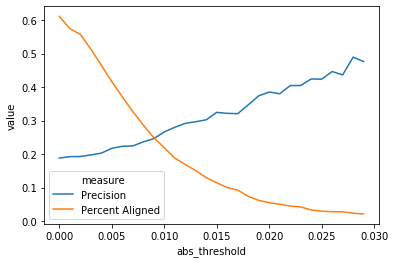

In [37]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [38]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = compare_bleu_score(input_data, abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.028
Precision:	 0.48936170212765956
Recall:		 0.09504132231404959
F1 score:	 0.15916955017301038
Percent aligned: 0.023606228026117528


In [39]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = compare_bleu_score(input_data, abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.015
Precision:	 0.32456140350877194
Recall:		 0.30578512396694213
F1 score:	 0.3148936170212766
Percent aligned: 0.11451531893520844


## TF-IDF vector similarity (w/ stopword removal and lemmatization)

Includes ingredients in the TF-IDF context (not recipe description yet)

In [40]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc.lower()) if t not in stopwords.words('english')]

all_text_ing = raw_df.apply(
    lambda x: x['question_text'] + ' ' + ' '.join(x['steps']) + ' ' + x['ingredients'], axis=1).values

tfidf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer())
tfidf_vectorizer.fit(all_text_ing)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<__main__.LemmaTokenizer object at 0x7fa8e0a2cda0>,
                use_idf=True, vocabulary=None)

In [41]:
def compare_tfidf_similarity(input_data, tfidf_vectorizer, abs_threshold=0.0):
    y_true, y_pred, all_tfidf_similarities, input_idx = [], [], [], []
    for idx, row in input_data.iterrows():
        question_vector = tfidf_vectorizer.transform([row['question_text']])
        step_vector = tfidf_vectorizer.transform([row['step_text']])
        # Calculate similarity between question and step vector
        similarity = cosine_similarity(question_vector.reshape(1,-1), step_vector.reshape(1,-1))

        # Jaccard similarity
#         question_vector = np.squeeze(np.asarray(question_vector.todense()))
#         step_vector = np.squeeze(np.asarray(step_vector.todense()))
#         similarity = jaccard_similarity(question_vector, step_vector, binary=False)

        if similarity > abs_threshold:
            pred = 1
        else:
            pred = 0
        y_true.append(row['aligned'])
        y_pred.append(pred)
        all_tfidf_similarities.append(similarity)
        input_idx.append(idx)
    return y_true, y_pred, all_tfidf_similarities, input_idx

def make_precision_plot_tfidf(input_data, tfidf_vectorizer, abs_threshold_range=(0, .11, .02)):
    threshold_df = pd.DataFrame(columns=['abs_threshold', 'measure', 'value'])
    for abs_threshold in abs_threshold_range:
        y_true, y_pred, count_scores, input_idx = compare_tfidf_similarity(
            input_data, tfidf_vectorizer, abs_threshold=abs_threshold)
        precision = precision_score(y_true, y_pred)
        percent_aligned = sum(y_pred)/len(input_data)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Precision', 'value': precision}, ignore_index=True)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Percent Aligned', 'value': percent_aligned}, ignore_index=True)
    return threshold_df

In [42]:
threshold_df = make_precision_plot_tfidf(input_data, tfidf_vectorizer, abs_threshold_range=np.arange(0, .81, .05))

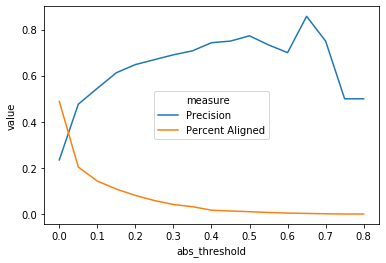

In [43]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [44]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = compare_tfidf_similarity(
    input_data, tfidf_vectorizer, abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.5
Precision:	 0.7727272727272727
Recall:		 0.07024793388429752
F1 score:	 0.1287878787878788
Percent aligned: 0.011049723756906077


In [45]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = compare_tfidf_similarity(
    input_data, tfidf_vectorizer, abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.15000000000000002
Precision:	 0.6129032258064516
Recall:		 0.5495867768595041
F1 score:	 0.579520697167756
Percent aligned: 0.1089904570567554


## Compare embedding similarity performance

### Words

In [ ]:
with open('/alhegel/scrapes/glove.twitter.27B.200d.txt', 'r') as glove_file:
    for i, line in enumerate(glove_file):
        if i == 38522:
            print(line.encode('utf-8'))

In [47]:
# Load GloVe embeddings files into memory for fast access
def make_glove_lookup_dict(input_file):
    glove_dict = {}
    with open(input_file, 'r') as glove_file:
        for i, line in enumerate(glove_file):
            line = line.split(' ')
            word = line[0]
            embeddings = line[1:]
            embeddings = np.array([float(x.strip()) for x in embeddings]).reshape(1, -1)
            glove_dict[word] = embeddings
    return glove_dict

data_dir = '/alhegel/scrapes/'
glove_twitter_dict = make_glove_lookup_dict(data_dir + 'glove.twitter.27B.200d.txt')
glove_cc_dict = make_glove_lookup_dict(data_dir + 'glove.840B.300d.txt')
glove_recipe_dict = make_glove_lookup_dict(data_dir + 'commoncrawl_scrapes_vectors_onlyinstructions.txt')

In [48]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()
bert_masked_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
bert_masked_model.eval()

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_model.eval()

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2Model.from_pretrained('gpt2')
gpt2_model.eval()
gpt2_head_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_head_model.eval()
gpt2_double_model = GPT2DoubleHeadsModel.from_pretrained('gpt2')
gpt2_double_model.eval()

xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
xlnet_model = XLNetModel.from_pretrained('xlnet-large-cased', output_hidden_states=True)
xlnet_model.eval()
xlnet_head_model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased')
xlnet_head_model.eval()
xlnet_seq_model = XLNetForSequenceClassification.from_pretrained('xlnet-large-cased')
xlnet_seq_model.eval()

bert_sentence_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [49]:
def get_embeddings(sentence, model_name):
    if model_name == 'GloVe Twitter':
        sentence_list = word_tokenize(sentence.lower())
        vector = []
        for word in sentence_list:
            if word in glove_twitter_dict:
                vector.append(glove_twitter_dict[word])
            else:
                vector.append(np.expand_dims(np.array([0.0] * 200), axis=0))
    elif model_name == 'GloVe CC':
        sentence_list = word_tokenize(sentence.lower())
        vector = []
        for word in sentence_list:
            if word in glove_cc_dict:
                vector.append(glove_cc_dict[word])
            else:
                vector.append(np.expand_dims(np.array([0.0] * 300), axis=0))
    elif model_name == 'GloVe Recipe':
        sentence_list = word_tokenize(sentence.lower())
        vector = []
        for word in sentence_list:
            if word in glove_recipe_dict:
                vector.append(glove_recipe_dict[word])
            else:
                vector.append(np.expand_dims(np.array([0.0] * 300), axis=0))
    elif model_name == 'BertModel':
        input_ids = torch.tensor(bert_tokenizer.encode(sentence)).unsqueeze(0)
        for remove_val in [101, 102]:  # remove [CLS] and [SEP] tokens
            input_ids = input_ids[input_ids != remove_val]
        input_ids = input_ids[:512]  # max token index sequence length is 512
        with torch.no_grad():
            vector = bert_model.embeddings.word_embeddings.weight[input_ids, :]
        vector = [np.expand_dims(v.detach().numpy(), axis=0) for v in vector]
    elif model_name == 'BertForMaskedLM':
        input_ids = torch.tensor(bert_tokenizer.encode(sentence)).unsqueeze(0)
        for remove_val in [101, 102]:  # remove [CLS] and [SEP] tokens
            input_ids = input_ids[input_ids != remove_val]
        input_ids = input_ids[:512]  # max token index sequence length is 512
        with torch.no_grad():
            last_hidden_states = bert_masked_model(input_ids[None, :])[0]
        vector = last_hidden_states[0]
        vector = [np.expand_dims(v.detach().numpy(), axis=0) for v in vector]
    elif model_name == 'RobertaModel':
        input_ids = torch.tensor(roberta_tokenizer.encode(sentence)).unsqueeze(0)
        for remove_val in [0, 1, 2]:  # remove <s> and </s> tokens
            input_ids = input_ids[input_ids != remove_val]
        input_ids = input_ids[:512]  # max token index sequence length is 512
        with torch.no_grad():
            vector = roberta_model.embeddings.word_embeddings.weight[input_ids, :]
        vector = [np.expand_dims(v.detach().numpy(), axis=0) for v in vector]
    elif model_name == 'GPT2Model':
        input_ids = torch.tensor(gpt2_tokenizer.encode(sentence, add_prefix_space=True))
        with torch.no_grad():
            vector = gpt2_model(input_ids)[0]
        vector = [np.expand_dims(v.detach().numpy(), axis=0) for v in vector]
    elif model_name == 'GPT2LMHeadModel':
        input_ids = gpt2_tokenizer.encode(sentence, add_prefix_space=True)
        with torch.no_grad():
            vector = gpt2_head_model.transformer.wte.weight[input_ids, :]
        vector = [np.expand_dims(v.detach().numpy(), axis=0) for v in vector]
    elif model_name == 'GPT2DoubleHeadsModel':
        input_ids = gpt2_tokenizer.encode(sentence, add_prefix_space=True)
        with torch.no_grad():
            vector = gpt2_double_model.transformer.wte.weight[input_ids, :]
        vector = [np.expand_dims(v.detach().numpy(), axis=0) for v in vector]
    elif model_name == 'XLNetModel':
        input_ids = torch.tensor(xlnet_tokenizer.encode(sentence)).unsqueeze(0)
        for remove_val in [3, 4]:  # remove <sep> and <cls> tokens
            input_ids = input_ids[input_ids != remove_val]
        with torch.no_grad():
            logits, hidden_layers = xlnet_model(input_ids[None, :])
        # transform 25 hidden layers into one vector for each word
        token_embeddings = []  # will have the shape [tokens, layers, features]
        for token_num in range(len(input_ids)):
            token_hidden_layers = []
            for layer_num in range(len(hidden_layers)):
                vec = hidden_layers[layer_num][0][token_num]  # [0] is batch number
                token_hidden_layers.append(vec)
            token_embeddings.append(token_hidden_layers)
        concatenated_last_4_layers = [torch.cat((layer[-1], layer[-2], layer[-3], layer[-4]), 0) for layer in token_embeddings] # [number_of_tokens, 3072]
        summed_last_4_layers = [torch.sum(torch.stack(layer)[-4:], 0) for layer in token_embeddings] # [number_of_tokens, 768]
        second_to_last_layer = [layer[-2] for layer in token_embeddings]
        vector = [np.expand_dims(v.detach().numpy(), axis=0) for v in second_to_last_layer]
    elif model_name == 'XLNetLMHeadModel':
        pass
    elif model_name == 'XLNetForSequenceClassification':
        pass
    return vector

In [ ]:
# %%capture
model_names = ['GloVe Twitter', 'GloVe CC', 'GloVe Recipe', 'BertModel', 'BertForMaskedLM', 'RobertaModel',
               'GPT2Model', 'GPT2LMHeadModel', 'GPT2DoubleHeadsModel', 'XLNetModel']
test_sentence = 'dog puppy car'

comparison_results = []
for model_name in model_names:
    print(model_name)
    vector = get_embeddings(test_sentence, model_name)
    comp1 = cosine_similarity(vector[0], vector[1]).item(0)
    comp2 = cosine_similarity(vector[0], vector[2]).item(0)
    if isinstance(model_name, str):
        model_name = model_name
    else:
        model_name = model_name.__name__
    comparison_results.append({'model': model_name, 'cosine similarity': comp1, 'comparison': 'dog-puppy'})
    comparison_results.append({'model': model_name, 'cosine similarity': comp2, 'comparison': 'dog-car'})

In [51]:
comparison_results_df = pd.DataFrame(comparison_results)
comparison_results_df

,model,cosine similarity,comparison
0,GloVe Twitter,0.789041,dog-puppy
1,GloVe Twitter,0.527168,dog-car
2,GloVe CC,0.858521,dog-puppy
3,GloVe CC,0.356292,dog-car
4,GloVe Recipe,0.041042,dog-puppy
5,GloVe Recipe,0.220686,dog-car
6,BertModel,0.495211,dog-puppy
7,BertModel,0.380798,dog-car
8,BertForMaskedLM,0.993495,dog-puppy
9,BertForMaskedLM,0.993013,dog-car


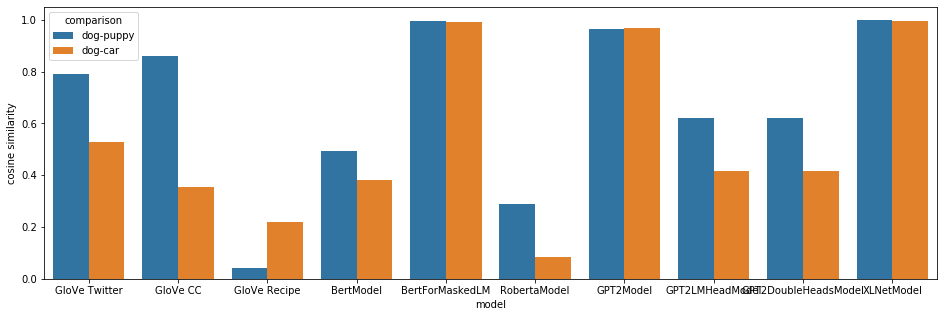

In [52]:
plt.figure(figsize=(16, 5))
sns.barplot(x='model', y='cosine similarity', hue='comparison', data=comparison_results_df);

### Sentences

In [53]:
def get_mean_sentence_embedding(sentence, model_name):  # for numpy arrays
    vector = get_embeddings(sentence, model_name)
    mean_vector = np.average(vector, axis=0)
    return mean_vector

def get_mean_sentence_embedding_tensor(sentence, model_name):
    vector = get_embeddings(sentence, model_name)
    mean_vector = torch.stack(tuple(vector), dim=0).mean(dim=0)
    return mean_vector

def get_max_pooled_sentence_embedding(sentence, model_name):  # for numpy arrays
    vector = get_embeddings(sentence, model_name)
    max_pooled_vector = np.max(vector, axis=0)
    return max_pooled_vector

def get_max_pooled_sentence_embedding_tensor(sentence, model_name):
    vector = get_embeddings(sentence, model_name)
    max_pooled_vector = vector[0]
    for i in range(vector.shape[0] - 1):  # for each word
        max_pooled_vector = torch.max(vector[i], vector[i+1])
    return max_pooled_vector

In [54]:
model_names = ['GloVe Twitter', 'GloVe CC', 'GloVe Recipe', 'BertModel', 'BertForMaskedLM', 'BertSentenceModel',
               'RobertaModel', 'GPT2Model', 'GPT2LMHeadModel', 'GPT2DoubleHeadsModel', 'XLNetModel']
sample_input_data = pd.DataFrame({'question_text': ['Do you have a suggestion for an alternative to xanthium gum to use as a binding source?'],
                                  'steps': [['Sift the flour into a large mixing bowl and add the xanthium Gum and salt.',
                                             'The pasties can now be placed into the oven for 40 minutes, or a little longer for a crispier and more golden crust. Remove from the oven and place on a cooling rack - or straight onto a plate if you can\'t wait!',
                                             'Carefully lift the other half of the base over the first filled half.']],
                                  'correct_id_idx': [1]})
sample_input_data = pd.DataFrame({'question_text': ['Do you have a suggestion for an alternative to xanthium gum to use as a binding source?'],
                                  'steps': [['Sift the flour into a large mixing bowl and add the xanthium Gum and salt.',
                                             'The pasties can now be placed into the oven for 40 minutes, or a little longer for a crispier and more golden crust. Remove from the oven and place on a cooling rack - or straight onto a plate if you can\'t wait!',
                                             'Carefully lift the other half of the base over the first filled half. Lamb and mint work amazingly well - or even apple and cinnamon with some custard.']],
                                  'correct_id_idx': [1]})
sample_input_data = pd.DataFrame({'question_text': ['Do you have a suggestion for an alternative to xanthium gum to use as a binding source?',
                                                    'Do you have a suggestion for an alternative to xanthium gum to use as a binding source?',
                                                    'Do you have a suggestion for an alternative to xanthium gum to use as a binding source?'],
                                  'step_text': ['You must have a suggestion for an alternative to xanthium gum to use as a binding source!',
                                                'The pasties can now be placed into the oven for 40 minutes, or a little longer for a crispier and more golden crust. Remove from the oven and place on a cooling rack - or straight onto a plate if you can\'t wait!',
                                                'No comment.'],
                                  'step_id': ['Step 1', 'Step 2', 'Step 3'],
                                  'aligned': [1, 0, 0]})

In [ ]:
# %%capture
comparison_results = []
for idx, row in sample_input_data.iterrows():
    for model_name in model_names:
        print(model_name)
        if model_name == 'BertSentenceModel':
            question_vector = bert_sentence_model.encode([row['question_text']])[0].reshape(1, -1)
            step_vector = bert_sentence_model.encode([row['step_text']])[0].reshape(1, -1)
            print(step_vector.shape)
            similarity = cosine_similarity(question_vector, step_vector).item(0)
        else:
            question_vector = get_mean_sentence_embedding(row['question_text'], model_name)
            print(question_vector.shape)
            step_vector = get_mean_sentence_embedding(row['step_text'], model_name)
            similarity = cosine_similarity(question_vector, step_vector).item(0)
        comparison_results.append({'model': model_name, 'cosine similarity': similarity, 'comparison': row['step_id']})

In [56]:
comparison_results_df = pd.DataFrame(comparison_results)
comparison_results_df

,model,cosine similarity,comparison
0,GloVe Twitter,0.993180,Step 1
1,GloVe CC,0.992431,Step 1
2,GloVe Recipe,0.984688,Step 1
3,BertModel,0.991452,Step 1
4,BertForMaskedLM,0.981516,Step 1
5,BertSentenceModel,0.914170,Step 1
6,RobertaModel,0.965393,Step 1
7,GPT2Model,0.999698,Step 1
8,GPT2LMHeadModel,0.990763,Step 1
9,GPT2DoubleHeadsModel,0.990763,Step 1


In [57]:
print('QUESTION:', sample_input_data.iloc[0]['question_text'], '\n')
for idx, row in sample_input_data.iterrows():
    print(row['step_text'], '\n')

QUESTION: Do you have a suggestion for an alternative to xanthium gum to use as a binding source? 

You must have a suggestion for an alternative to xanthium gum to use as a binding source! 

The pasties can now be placed into the oven for 40 minutes, or a little longer for a crispier and more golden crust. Remove from the oven and place on a cooling rack - or straight onto a plate if you can't wait! 

No comment. 



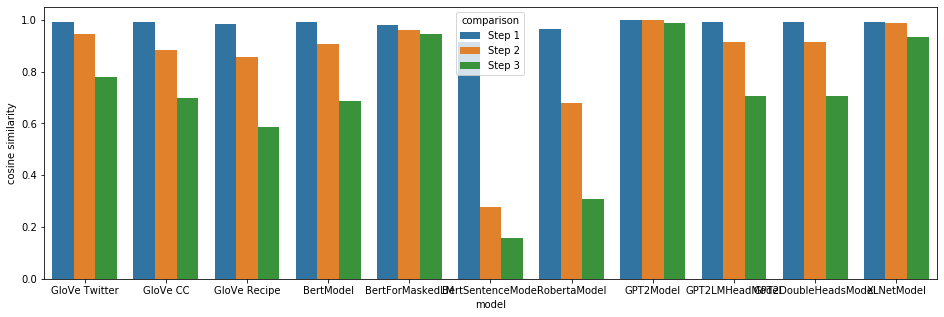

In [58]:
plt.figure(figsize=(16, 5))
sns.barplot(x='model', y='cosine similarity', hue='comparison', data=comparison_results_df);

## Try Sentence Embedding Similarity Methods on Instructables data

In [59]:
def get_embedding_predictions(input_data, model_name, abs_threshold=0.0):
    y_true, y_pred, all_similarity_scores, input_idx = [], [], [], []
    for idx, row in input_data.iterrows():
        if model_name == 'BertSentenceModel':
            question_vector = bert_sentence_model.encode([row['question_text']])[0].reshape(1, -1)
            step_vector = bert_sentence_model.encode([row['step_text']])[0].reshape(1, -1)
            similarity = cosine_similarity(question_vector, step_vector).item(0)
            
            # Jaccard similarity
#             question_vector = bert_sentence_model.encode([row['question_text']])[0]
#             step_vector = bert_sentence_model.encode([row['step_text']])[0]
#             question_vector = np.squeeze(np.asarray(question_vector.todense()))
#             step_vector = np.squeeze(np.asarray(step_vector.todense()))
#             similarity = jaccard_similarity(question_vector, step_vector, binary=False)
        else:
            question_vector = get_mean_sentence_embedding(row['question_text'], model_name)
            step_vector = get_mean_sentence_embedding(row['step_text'], model_name)
            similarity = cosine_similarity(question_vector, step_vector).item(0)
            
            # Jaccard similarity
#             question_vector = get_mean_sentence_embedding(row['question_text'], model_name)[0]
#             step_vector = get_mean_sentence_embedding(row['step_text'], model_name)[0]
#             similarity = jaccard_similarity(question_vector, step_vector, binary=False)
        if similarity > abs_threshold:
            pred = 1
        else:
            pred = 0
        y_true.append(row['aligned'])
        y_pred.append(pred)
        all_similarity_scores.append(similarity)
        input_idx.append(idx)
    return y_true, y_pred, all_similarity_scores, input_idx

def make_precision_plot_embeddings(input_data, model_name, abs_threshold_range=np.arange(0, .11, .02)):
    threshold_df = pd.DataFrame(columns=['abs_threshold', 'measure', 'value'])
    for abs_threshold in abs_threshold_range:
        y_true, y_pred, all_similarity_scores, input_idx = get_embedding_predictions(
            input_data, model_name, abs_threshold=abs_threshold)
        precision = precision_score(y_true, y_pred)
        percent_aligned = sum(y_pred)/len(input_data)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Precision', 'value': precision}, ignore_index=True)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Percent Aligned', 'value': percent_aligned}, ignore_index=True)
    return threshold_df

### GloVe Twitter

In [60]:
%%capture
threshold_df = make_precision_plot_embeddings(input_data, 'GloVe Twitter', abs_threshold_range=np.arange(0.5, 1.1, .05))

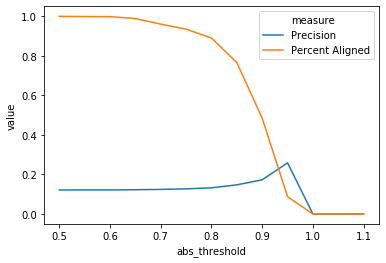

In [61]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [62]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions(
    input_data, 'GloVe Twitter', abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.9500000000000004
Precision:	 0.25862068965517243
Recall:		 0.1859504132231405
F1 score:	 0.21634615384615383
Percent aligned: 0.0873932697137117


In [63]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions(
    input_data, 'GloVe Twitter', abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.9000000000000004
Precision:	 0.17323651452282157
Recall:		 0.6900826446280992
F1 score:	 0.27694859038142616
Percent aligned: 0.48417880462079355


### GloVe CC

In [64]:
%%capture
threshold_df = make_precision_plot_embeddings(input_data, 'GloVe CC', abs_threshold_range=np.arange(0.5, 1.1, .05))

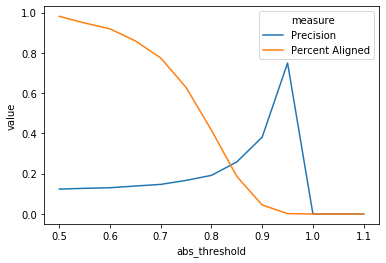

In [65]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [66]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions(
    input_data, 'GloVe CC', abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.9000000000000004
Precision:	 0.38202247191011235
Recall:		 0.14049586776859505
F1 score:	 0.20543806646525678
Percent aligned: 0.04470115519839277


In [67]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions(
    input_data, 'GloVe CC', abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.8500000000000003
Precision:	 0.2587601078167116
Recall:		 0.39669421487603307
F1 score:	 0.3132137030995106
Percent aligned: 0.18633852335509793


### GloVe Recipe

In [68]:
%%capture
threshold_df = make_precision_plot_embeddings(input_data, 'GloVe Recipe', abs_threshold_range=np.arange(0.5, 1.1, .05))

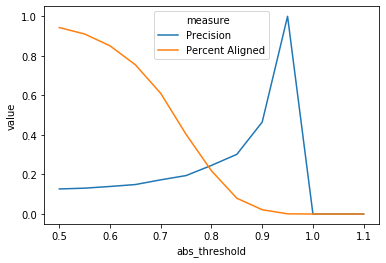

In [69]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [70]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions(
    input_data, 'GloVe Recipe', abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.9000000000000004
Precision:	 0.46511627906976744
Recall:		 0.08264462809917356
F1 score:	 0.14035087719298245
Percent aligned: 0.021597187343043698


In [71]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions(
    input_data, 'GloVe Recipe', abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.8000000000000003
Precision:	 0.24597701149425288
Recall:		 0.44214876033057854
F1 score:	 0.3161004431314623
Percent aligned: 0.21848317428427927


### BertSentenceModel

https://github.com/UKPLab/sentence-transformers

In [72]:
%%capture
threshold_df = make_precision_plot_embeddings(input_data, 'BertSentenceModel',
                                              abs_threshold_range=np.arange(.5, .91, .1))

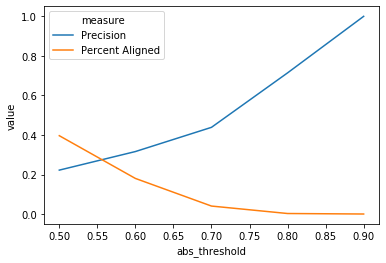

In [73]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [74]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions(
    input_data, 'BertSentenceModel', abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.7
Precision:	 0.43902439024390244
Recall:		 0.1487603305785124
F1 score:	 0.22222222222222224
Percent aligned: 0.04118533400301356


In [75]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions(
    input_data, 'BertSentenceModel', abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.6
Precision:	 0.31666666666666665
Recall:		 0.47107438016528924
F1 score:	 0.3787375415282392
Percent aligned: 0.1808136614766449


### RoBERTa

In [76]:
%%capture
threshold_df = make_precision_plot_embeddings(input_data, 'RobertaModel', abs_threshold_range=np.arange(.3, .91, .1))

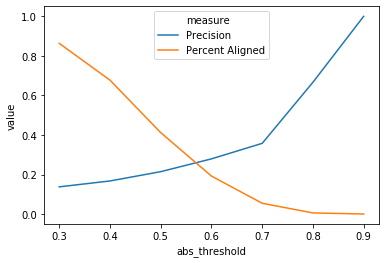

In [77]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [78]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions(
    input_data, 'RobertaModel', abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.7000000000000002
Precision:	 0.3577981651376147
Recall:		 0.16115702479338842
F1 score:	 0.22222222222222224
Percent aligned: 0.05474635861376193


In [79]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions(
    input_data, 'RobertaModel', abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.6000000000000001
Precision:	 0.2793733681462141
Recall:		 0.44214876033057854
F1 score:	 0.34240000000000004
Percent aligned: 0.19236564540431944


## Upweight ingredient words

In [80]:
# Method:
word1 = np.array([1,2,1,1])
word2 = np.array([0,0,0,0])
weights = np.array([.75,.25])
np.average([word1, word2], axis=0, weights=weights)

array([0.75, 1.5 , 0.75, 0.75])

In [81]:
def get_mean_sentence_embeddings_ing_weighted(sentence, model_name, weight_text):
    # tokenize the sentence to be weighted
    if model_name in ['BertModel', 'BertForMaskedLM']:
        tokenizer = bert_tokenizer
    elif model_name in ['RobertaModel']:
        tokenizer = roberta_tokenizer
    elif model_name in ['GPT2Model', 'GPT2LMHeadModel', 'GPT2DoubleHeadsModel']:
        tokenizer = gpt2_tokenizer
    elif model_name in ['XLNetModel', 'XLNetLMHeadModel', 'XLNetForSequenceClassification']:
        tokenizer = xlnet_tokenizer
    if model_name in ['GPT2Model', 'GPT2LMHeadModel', 'GPT2DoubleHeadsModel']:
        text_index = tokenizer.encode(sentence, add_prefix_space=True)
    else:
        text_index = tokenizer.encode(sentence)
    sentence_words = [tokenizer.decode(t) for t in text_index]
    for remove_val in ['[CLS]', '[SEP]', '<cls>', '<sep>', '<s>', '</s>']:  # remove [CLS] and [SEP] tokens
        if remove_val in sentence_words:
            sentence_words.remove(remove_val)
    sentence_words = sentence_words[:512]
    
    # also tokenize the text you're going to upweight (remove punctuation and stopwords)
    weight_text = weight_text.lower().translate(str.maketrans('', '', string.punctuation))
    weight_text = [t for t in word_tokenize(weight_text) if t not in stopwords.words('english')]
    weight_text = ' '.join(weight_text)
    weight_text = tokenizer.encode(weight_text)

    # calculate weights for each word in the sentence
    weights = np.array([])
    for sentence_word in sentence_words:
        if sentence_word.lower().strip() in weight_text:
#             print('match:', sentence_word)
            weights = np.append(weights, 10)
        else:
            weights = np.append(weights, 1)
    weights = np.divide(weights, weights.sum())

    # calculate weighted mean
    sentence_vector = get_embeddings(sentence, model_name)  # vector size len(sentence_words) x 768
    weighted_mean_vector = np.average(sentence_vector, axis=0, weights=weights)
    return weighted_mean_vector

In [82]:
def get_embedding_predictions_ing_weighted(ing_input_data, model_name, abs_threshold=0.0):
    y_true, y_pred, all_similarity_scores, input_idx = [], [], [], []
    for idx, row in ing_input_data.iterrows():
        ingredient_text = str(row['ingredients'])
        if model_name == 'BertSentenceModel':
            question_vector = bert_sentence_model.encode([row['question_text']])[0].reshape(1, -1)
            step_vector = bert_sentence_model.encode([row['step_text']])[0].reshape(1, -1)
            similarity = cosine_similarity(question_vector, step_vector).item(0)
        else:
            question_vector = get_mean_sentence_embeddings_ing_weighted(
                row['question_text'], model_name, ingredient_text).reshape(1, -1)
            step_vector = get_mean_sentence_embeddings_ing_weighted(
                row['step_text'], model_name, ingredient_text).reshape(1, -1)
            similarity = cosine_similarity(question_vector, step_vector).item(0)
        if similarity > abs_threshold:
            pred = 1
        else:
            pred = 0
        y_true.append(row['aligned'])
        y_pred.append(pred)
        all_similarity_scores.append(similarity)
        input_idx.append(idx)
    return y_true, y_pred, all_similarity_scores, input_idx

def make_precision_plot_embeddings_ing_weighted(input_data, model_name, abs_threshold_range=np.arange(0, .11, .02)):
    threshold_df = pd.DataFrame(columns=['abs_threshold', 'measure', 'value'])
    for abs_threshold in abs_threshold_range:
        y_true, y_pred, all_similarity_scores, input_idx = get_embedding_predictions_ing_weighted(
            input_data, model_name, abs_threshold=abs_threshold)
        precision = precision_score(y_true, y_pred)
        percent_aligned = sum(y_pred)/len(input_data)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Precision', 'value': precision}, ignore_index=True)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Percent Aligned', 'value': percent_aligned}, ignore_index=True)
    return threshold_df

### BertSentenceModel

In [83]:
# %%capture
threshold_df = make_precision_plot_embeddings_ing_weighted(ing_input_data, 'BertSentenceModel',
                                                           abs_threshold_range=np.arange(0.0, 1.1, .1))

/home/alhegel/.conda/envs/recipeqa/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


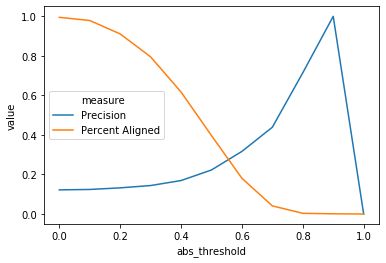

In [84]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [85]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions_ing_weighted(
    ing_input_data, 'BertSentenceModel', abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.7000000000000001
Precision:	 0.43902439024390244
Recall:		 0.1487603305785124
F1 score:	 0.22222222222222224
Percent aligned: 0.04118533400301356


In [86]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions_ing_weighted(
    ing_input_data, 'BertSentenceModel', abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.6000000000000001
Precision:	 0.31666666666666665
Recall:		 0.47107438016528924
F1 score:	 0.3787375415282392
Percent aligned: 0.1808136614766449


### RobertaModel

In [87]:
# %%capture
threshold_df = make_precision_plot_embeddings_ing_weighted(ing_input_data, 'RobertaModel',
                                                           abs_threshold_range=np.arange(0.0, 1.1, .1))

/home/alhegel/.conda/envs/recipeqa/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


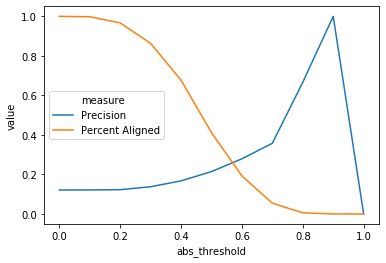

In [88]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [89]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions_ing_weighted(
    ing_input_data, 'RobertaModel', abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.7000000000000001
Precision:	 0.3577981651376147
Recall:		 0.16115702479338842
F1 score:	 0.22222222222222224
Percent aligned: 0.05474635861376193


In [90]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions_ing_weighted(
    ing_input_data, 'RobertaModel', abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.6000000000000001
Precision:	 0.2793733681462141
Recall:		 0.44214876033057854
F1 score:	 0.34240000000000004
Percent aligned: 0.19236564540431944


## Weight embeddings by TF-IDF

When averaging words for the sentence embedding, only considers words with TF-IDF weights (no stopwords).

Includes ingredients in the TF-IDF context (not recipe description yet)

Not lemmatized (not sure how to integrate that with GPT-2)

In [91]:
def get_mean_sentence_embeddings_tfidf_weighted(sentence, model_name, tfidf_vectorizer):
    # tokenize the sentence to be weighted
    if model_name in ['BertModel', 'BertForMaskedLM']:
        tokenizer = bert_tokenizer
    elif model_name in ['RobertaModel']:
        tokenizer = roberta_tokenizer
    elif model_name in ['GPT2Model', 'GPT2LMHeadModel', 'GPT2DoubleHeadsModel']:
        tokenizer = gpt2_tokenizer
    elif model_name in ['XLNetModel', 'XLNetLMHeadModel', 'XLNetForSequenceClassification']:
        tokenizer = xlnet_tokenizer
    if model_name in ['GPT2Model', 'GPT2LMHeadModel', 'GPT2DoubleHeadsModel']:
        text_index = tokenizer.encode(sentence, add_prefix_space=True)
    else:
        text_index = tokenizer.encode(sentence)
    sentence_words = [tokenizer.decode(t) for t in text_index]
    for remove_val in ['[CLS]', '[SEP]', '<cls>', '<sep>', '<s>', '</s>']:  # remove [CLS] and [SEP] tokens
        if remove_val in sentence_words:
            sentence_words.remove(remove_val)
    sentence_words = sentence_words[:512]
    
    # get TF-IDF scores for each word in sentence to use as embedding weights
    tfidf_features = tfidf_vectorizer.get_feature_names()
    tfidf_weights = tfidf_vectorizer.transform([sentence]).todense()

    # calculate TF-IDF weights for each word in the sentence
    weights = np.array([])
    for sentence_word in sentence_words:
        clean_sentence_word = sentence_word.lower().strip()
        if clean_sentence_word in tfidf_features:
#             print('match:', sentence_word)
            idx_of_tfidf_weight = tfidf_features.index(clean_sentence_word)
            weights = np.append(weights, tfidf_weights[:,idx_of_tfidf_weight])
        else:
            weights = np.append(weights, 0)
    weights = np.divide(weights, weights.sum())

    # calculate weighted mean
    sentence_vector = get_embeddings(sentence, model_name)  # vector size len(sentence_words) x 768
    weighted_mean_vector = np.average(sentence_vector, axis=0, weights=weights)
    return weighted_mean_vector

In [92]:
def get_embedding_predictions_tfidf_weighted(input_data, model_name, abs_threshold=0.0):
    y_true, y_pred, all_similarity_scores, input_idx = [], [], [], []
    for idx, row in input_data.iterrows():
        ingredient_vector = row['ingredients']
        similarities = []
        if model_name == 'BertSentenceModel':
            question_vector = bert_sentence_model.encode([row['question_text']])[0].reshape(1, -1)
            step_vector = bert_sentence_model.encode([row['step_text']])[0].reshape(1, -1)
            similarity = cosine_similarity(question_vector, step_vector).item(0)
        else:
            question_vector = get_mean_sentence_embeddings_tfidf_weighted(
                row['question_text'], model_name, tfidf_vectorizer).reshape(1, -1)
            step_vector = get_mean_sentence_embeddings_tfidf_weighted(
                row['step_text'], model_name, tfidf_vectorizer).reshape(1, -1)
            similarity = cosine_similarity(question_vector, step_vector).item(0)
        if similarity > abs_threshold:
            pred = 1
        else:
            pred = 0
        y_true.append(row['aligned'])
        y_pred.append(pred)
        all_similarity_scores.append(similarity)
        input_idx.append(idx)
    return y_true, y_pred, all_similarity_scores, input_idx

def make_precision_plot_embeddings_tfidf_weighted(input_data, model_name,
                                                  abs_threshold_range=np.arange(0, .11, .02)):
    threshold_df = pd.DataFrame(columns=['abs_threshold', 'measure', 'value'])
    for abs_threshold in abs_threshold_range:
        y_true, y_pred, all_similarity_scores, input_idx = get_embedding_predictions_tfidf_weighted(
            input_data, model_name, abs_threshold=abs_threshold)
        precision = precision_score(y_true, y_pred)
        percent_aligned = sum(y_pred)/len(input_data)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Precision', 'value': precision}, ignore_index=True)
        threshold_df = threshold_df.append({'abs_threshold': abs_threshold,
            'measure': 'Percent Aligned', 'value': percent_aligned}, ignore_index=True)
    return threshold_df

### BertSentenceModel

In [93]:
%%capture
threshold_df = make_precision_plot_embeddings_tfidf_weighted(ing_input_data, 'BertSentenceModel',
                                                             abs_threshold_range=np.arange(0, 1.1, .1))

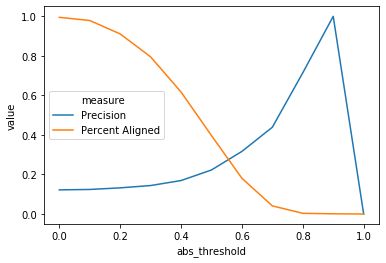

In [94]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [95]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions_tfidf_weighted(
    ing_input_data, 'BertSentenceModel', abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.7000000000000001
Precision:	 0.43902439024390244
Recall:		 0.1487603305785124
F1 score:	 0.22222222222222224
Percent aligned: 0.04118533400301356


In [96]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions_tfidf_weighted(
    ing_input_data, 'BertSentenceModel', abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.6000000000000001
Precision:	 0.31666666666666665
Recall:		 0.47107438016528924
F1 score:	 0.3787375415282392
Percent aligned: 0.1808136614766449


### RobertaModel

In [97]:
%%capture
threshold_df = make_precision_plot_embeddings_tfidf_weighted(ing_input_data, 'RobertaModel',
                                                             abs_threshold_range=np.arange(0, 1.1, .1))

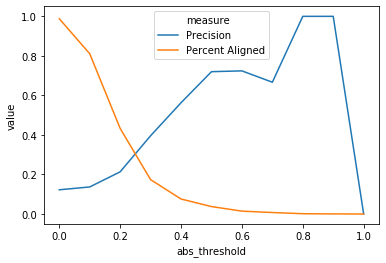

In [98]:
sns.lineplot(x='abs_threshold', y='value', hue='measure', data=threshold_df);

In [99]:
min_percent_aligned = .01
best_precision_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best precision threshold with at least', min_percent_aligned*100, '% aligned:', best_precision_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions_tfidf_weighted(
    ing_input_data, 'RobertaModel', abs_threshold=best_precision_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best precision threshold with at least 1.0 % aligned: 0.6000000000000001
Precision:	 0.7241379310344828
Recall:		 0.08677685950413223
F1 score:	 0.15498154981549817
Percent aligned: 0.014565544952285283


In [100]:
min_percent_aligned = .1
percent_aligned_threshold = find_threshold_with_best_precision(threshold_df, min_percent_aligned=min_percent_aligned)
print('Best threshold with at least', min_percent_aligned*100, '% aligned:', percent_aligned_threshold)
y_true, y_pred, count_scores, input_idx = get_embedding_predictions_tfidf_weighted(
    ing_input_data, 'RobertaModel', abs_threshold=percent_aligned_threshold)
show_classification_results(y_true, y_pred, input_idx, input_data)

Best threshold with at least 10.0 % aligned: 0.30000000000000004
Precision:	 0.3959537572254335
Recall:		 0.5661157024793388
F1 score:	 0.46598639455782315
Percent aligned: 0.1737820190858865


# Validation Data
134 hand-checked examples from Instructables.com

In [10]:
print('Question Text:\n', label_df.iloc[0]['question_text'], '\n')
print('Step ID:\n', label_df.iloc[0]['step_id'], '\n')
print('Step Text:\n', label_df.iloc[0]['step_text'], '\n')
print('Aligned:\n', label_df.iloc[0]['aligned'], '\n')
print('URL:\n', label_df.iloc[0]['url'], '\n')
print('Ingredients:\n', label_df.iloc[0]['ingredients'])

Question Text:
 Do these cookies freeze well? 

Step ID:
 0 

Step Text:
 Preheat oven to 350. 

Aligned:
 0 

URL:
 https://www.food.com/recipe/linzer-tarts-191826 

Ingredients:
 1   cup    margarine 1/2  cup    sugar 1   large    egg 2   cups    all-purpose flour 1   teaspoon    vanilla seedless raspberry preserves powdered sugar


# Results

### Best Precision (at least 1% aligned)
| Method                     | Precision | Recall | F1 Score | % Aligned
|---|---|---|---|---|
| Count Words in Common               | .90 | .07 | .13 |  1% |
| Count Words in Common (Lemmatized)  | .32 | .18 | .23 |  7% |
| Jaccard Similarity                  | .93 | .10 | .18 |  1% |
| BLEU Score                          | .49 | .10 | .16 |  2% |
| TF-IDF Vectors                      | .77 | .07 | .13 |  1% |
| GloVe Twitter                       | .26 | .19 | .22 |  9% |
| GloVe CommonCrawl                   | .38 | .14 | .21 |  4% |
| GloVe Recipe Data                   | .47 | .08 | .14 |  2% |
| BERT Sentence Model                 | .44 | .15 | .22 |  4% |
| RoBERTa                             | .36 | .16 | .22 |  5% |
| BERT w/ Ingredient Weighting        | .44 | .15 | .22 |  4% |
| RoBERTa w/ Ingredient Weighting     | .36 | .16 | .22 |  5% |
| BERT w/ TF-IDF Weighting            | .44 | .15 | .22 |  4% |
| RoBERTa w/ TF-IDF Weighting         | .72 | .09 | .15 |  1% |

### Best Precision (at least 10% aligned)
| Method                     | Precision | Recall | F1 Score | % Aligned
|---|---|---|---|---|
| Count Words in Common               | .56 | .46 | .51 | 10% |
| Count Words in Common (Lemmatized)  | .28 | .27 | .27 | 12% |
| Jaccard Similarity                  | .34 | .58 | .43 | 21% |
| BLEU Score                          | .32 | .31 | .31 | 11% |
| TF-IDF Vectors                      | .61 | .55 | .58 | 11% |
| GloVe Twitter                       | .17 | .69 | .28 | 48% |
| GloVe CommonCrawl                   | .26 | .40 | .31 | 19% |
| GloVe Recipe Data                   | .25 | .44 | .32 | 22% |
| BERT Sentence Model                 | .32 | .47 | .38 | 18% |
| RoBERTa                             | .28 | .44 | .34 | 19% |
| BERT w/ Ingredient Weighting        | .32 | .47 | .38 | 18% |
| RoBERTa w/ Ingredient Weighting     | .28 | .44 | .34 | 19% |
| BERT w/ TF-IDF Weighting            | .32 | .47 | .37 | 18% |
| RoBERTa w/ TF-IDF Weighting         | .40 | .57 | .47 | 17% |

* **Count Words in Common:** For each word in the question (ignoring stopwords), see how many times it occurs in the step, and add up across all words in the question. Take the step with the highest sum.
* **Count Words in Common (Lemmatized):** Same as above, but lemmatize words first.
* **BLEU Score:** Calculate BLEU score between the question and each step, ignoring punctuation. Take the step with the highest score.
* **TF-IDF Vector Cosine Similarity:** Transform questions and steps into TF-IDF vectors (removing stopwords and lemmatizing) and calculate the cosine similarity. Take the step with the highest cosine similarity. Uses questions, steps, and ingredients in the TF-IDF context.
* **GPT-2 Embedding Cosine Similarity:** Get the GPT-2 embedding for each word of the question and steps, average across the words, then calculate the cosine similarity between the question and each step. Take the step with the highest cosine similarity.
* **GPT-2 w/ Ingredient Weighting:** When calculating the mean embedding across all words in the question or step, give higher weight (10:1) to words in the ingredient list (ignoring stopwords and punctuation).
* **GPT-2 w/ TF-IDF Weighting:** When calculating the mean embedding across all words in the question or step, weight words in the ingredient list (ignoring stopwords) with their TF-IDF score, and ignore all other words. Uses questions, steps, and ingredients in the TF-IDF context.